In [1]:
import os
from os.path import join, exists
from glob import glob

from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
import torchvision

import requests

from PIL import Image, ImageFilter

/home/sungbeenpark/anaconda3/envs/attention/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
# os.environ["CUDA_VISIBLE_DEVICES"]= "1"  # Set the GPU number to use

In [3]:
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda:1


In [4]:
def check_memory(device):
    res = torch.cuda.memory_allocated(device)/(1024*1024*1024)
    print('%.1fGiB'%res)
    res = torch.cuda.memory_cached(device)/(1024*1024*1024)
    print('%.1fGiB'%res)

In [5]:
utils = torch.hub.load(
    repo_or_dir='NVIDIA/DeepLearningExamples:torchhub'
    , model='nvidia_convnets_processing_utils'
    , source='github'
)

Using cache found in /home/sungbeenpark/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/sungbeenpark/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/sungbeenpark/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


In [6]:
resnet50 = torch.hub.load(
    repo_or_dir='NVIDIA/DeepLearningExamples:torchhub'
    , model='nvidia_resnet50'
    , source='github'
    , pretrained=True
)
resnet50.eval().to(device)

Using cache found in /home/sungbeenpark/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layers): Sequential(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [7]:
check_memory(device)

0.1GiB
0.1GiB


/home/sungbeenpark/anaconda3/envs/attention/lib/python3.9/site-packages/torch/cuda/memory.py:395: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


---

To extract features

In [8]:
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor

In [9]:
list_node, _ = get_graph_node_names(resnet50)
print(list_node)

['x', 'conv1', 'bn1', 'relu', 'maxpool', 'layers.0.0.conv1', 'layers.0.0.bn1', 'layers.0.0.relu', 'layers.0.0.conv2', 'layers.0.0.bn2', 'layers.0.0.relu_1', 'layers.0.0.conv3', 'layers.0.0.bn3', 'layers.0.0.downsample.0', 'layers.0.0.downsample.1', 'layers.0.0.add', 'layers.0.0.relu_2', 'layers.0.1.conv1', 'layers.0.1.bn1', 'layers.0.1.relu', 'layers.0.1.conv2', 'layers.0.1.bn2', 'layers.0.1.relu_1', 'layers.0.1.conv3', 'layers.0.1.bn3', 'layers.0.1.add', 'layers.0.1.relu_2', 'layers.0.2.conv1', 'layers.0.2.bn1', 'layers.0.2.relu', 'layers.0.2.conv2', 'layers.0.2.bn2', 'layers.0.2.relu_1', 'layers.0.2.conv3', 'layers.0.2.bn3', 'layers.0.2.add', 'layers.0.2.relu_2', 'layers.1.0.conv1', 'layers.1.0.bn1', 'layers.1.0.relu', 'layers.1.0.conv2', 'layers.1.0.bn2', 'layers.1.0.relu_1', 'layers.1.0.conv3', 'layers.1.0.bn3', 'layers.1.0.downsample.0', 'layers.1.0.downsample.1', 'layers.1.0.add', 'layers.1.0.relu_2', 'layers.1.1.conv1', 'layers.1.1.bn1', 'layers.1.1.relu', 'layers.1.1.conv2', 'l

In [10]:
feature_extractor = create_feature_extractor(
    resnet50, return_nodes={
        'relu':'res1'
        , 'layers.0.2.relu_2':'res2'
        , 'layers.1.3.relu_2':'res3'
        , 'layers.2.5.relu_2':'res4'
        , 'layers.3.2.relu_2':'res5'
    }
)

---

Test #1

In [11]:
uris = [
    'http://images.cocodataset.org/test-stuff2017/000000024309.jpg',
    'http://images.cocodataset.org/test-stuff2017/000000028117.jpg',
    'http://images.cocodataset.org/test-stuff2017/000000006149.jpg',
    'http://images.cocodataset.org/test-stuff2017/000000004954.jpg',
    'https://images.mypetlife.co.kr/content/uploads/2018/07/09160052/puppy-1189067_1280.jpg',
    'https://static.scientificamerican.com/sciam/cache/file/3D3EBC0B-26CB-41F5-951EE45D02F52BE2_source.jpg?w=590&h=800&16015EBB-65BA-49B6-B58589FD87ED8469',
    'https://global.unitednations.entermediadb.net/assets/mediadb/services/module/asset/downloads/preset/Libraries/Production+Library/10-06-2021_Unsplash_chess.jpg/image1170x530cropped.jpg',
    '/mnt/ext5/DRN/behav_data/DRN04/Run1/1.png'
]

batch = torch.cat(
    [utils.prepare_input_from_uri(uri) for uri in uris]
).to(device)

In [12]:
with torch.no_grad():
    output = torch.nn.functional.softmax(resnet50(batch), dim=1)
    features = feature_extractor(batch)['res5']

results = utils.pick_n_best(predictions=output, n=5)

sample 0: [('laptop, laptop computer', '34.7%'), ('mouse, computer mouse', '11.8%'), ('notebook, notebook computer', '10.9%'), ('monitor', '3.9%'), ('web site, website, internet site, site', '3.1%')]
sample 1: [('mashed potato', '78.6%'), ('broccoli', '7.3%'), ('meat loaf, meatloaf', '2.6%'), ('plate', '1.8%'), ('guacamole', '0.2%')]
sample 2: [('racket, racquet', '25.3%'), ('tennis ball', '6.0%'), ('ping-pong ball', '2.0%'), ('catamaran', '0.3%'), ('bathtub, bathing tub, bath, tub', '0.3%')]
sample 3: [('groenendael', '12.7%'), ('Scottish deerhound, deerhound', '11.3%'), ('flat-coated retriever', '6.6%'), ('kelpie', '6.1%'), ('Great Dane', '3.1%')]
sample 4: [('golden retriever', '84.1%'), ('Labrador retriever', '1.0%'), ('clumber, clumber spaniel', '0.3%'), ('flat-coated retriever', '0.3%'), ('curly-coated retriever', '0.2%')]
sample 5: [('spotlight, spot', '6.3%'), ('buckeye, horse chestnut, conker', '3.6%'), ('candle, taper, wax light', '2.9%'), ('stove', '1.9%'), ("jack-o'-lantern

/tmp/ipykernel_18990/2547820517.py:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img.thumbnail(size=(256,256), resample=Image.ANTIALIAS)


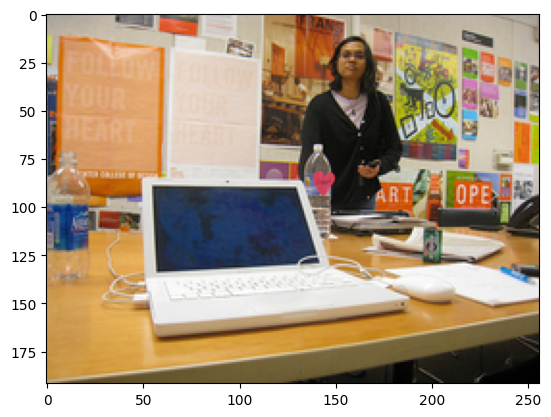

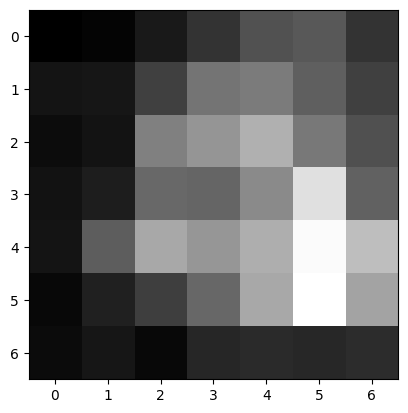

[('laptop, laptop computer', '34.7%'), ('mouse, computer mouse', '11.8%'), ('notebook, notebook computer', '10.9%'), ('monitor', '3.9%'), ('web site, website, internet site, site', '3.1%')]


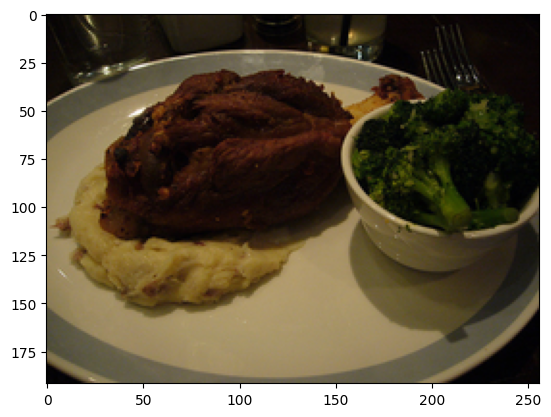

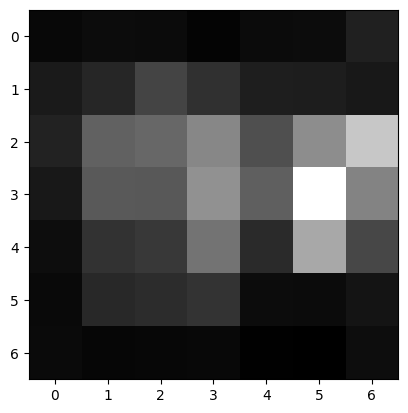

[('mashed potato', '78.6%'), ('broccoli', '7.3%'), ('meat loaf, meatloaf', '2.6%'), ('plate', '1.8%'), ('guacamole', '0.2%')]


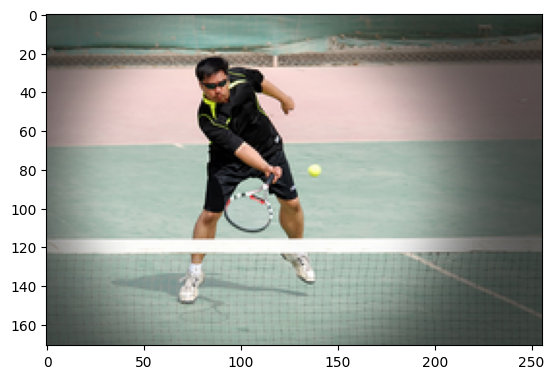

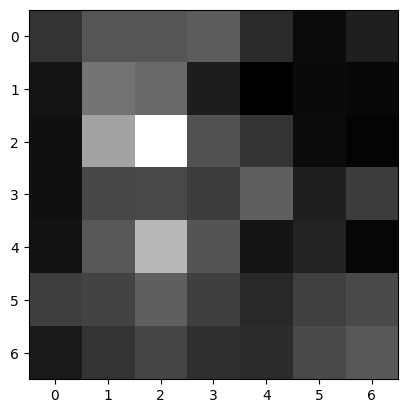

[('racket, racquet', '25.3%'), ('tennis ball', '6.0%'), ('ping-pong ball', '2.0%'), ('catamaran', '0.3%'), ('bathtub, bathing tub, bath, tub', '0.3%')]


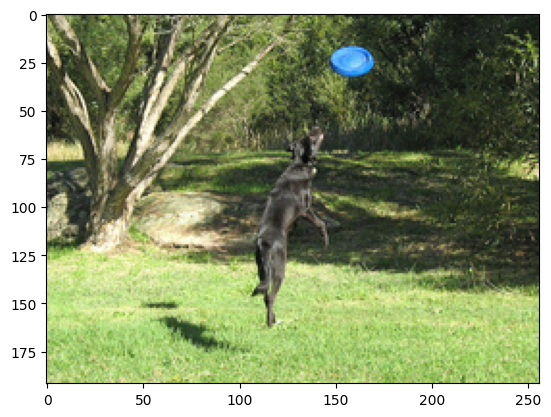

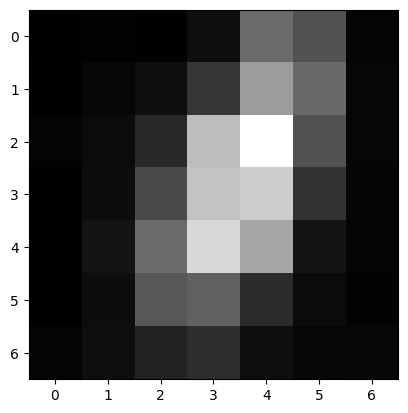

[('groenendael', '12.7%'), ('Scottish deerhound, deerhound', '11.3%'), ('flat-coated retriever', '6.6%'), ('kelpie', '6.1%'), ('Great Dane', '3.1%')]


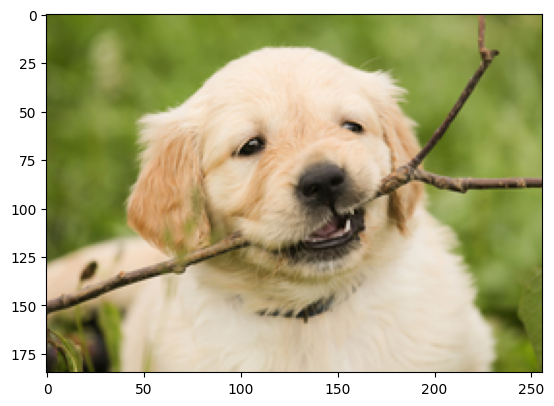

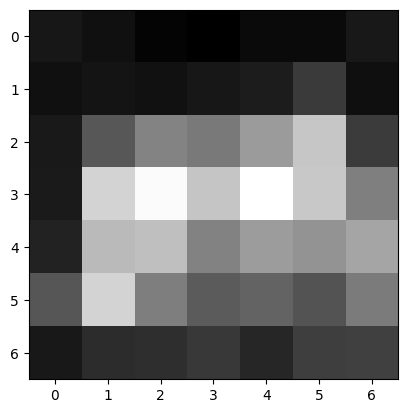

[('golden retriever', '84.1%'), ('Labrador retriever', '1.0%'), ('clumber, clumber spaniel', '0.3%'), ('flat-coated retriever', '0.3%'), ('curly-coated retriever', '0.2%')]


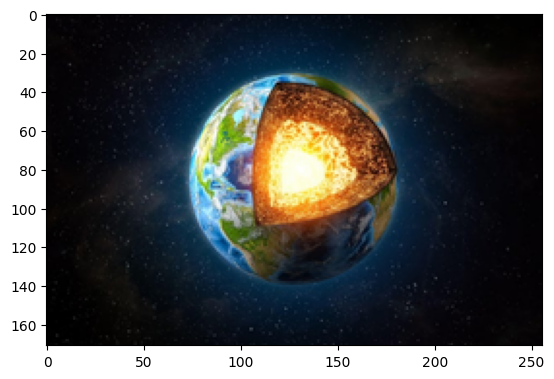

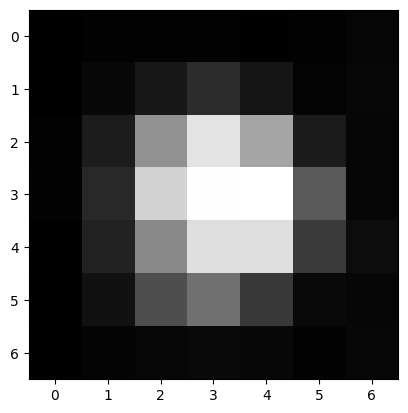

[('spotlight, spot', '6.3%'), ('buckeye, horse chestnut, conker', '3.6%'), ('candle, taper, wax light', '2.9%'), ('stove', '1.9%'), ("jack-o'-lantern", '1.7%')]


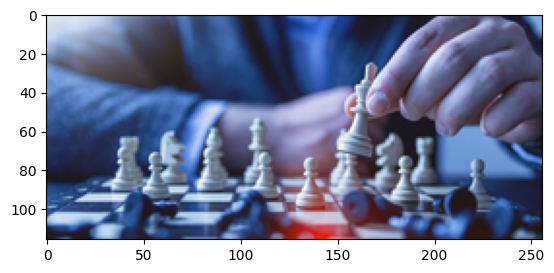

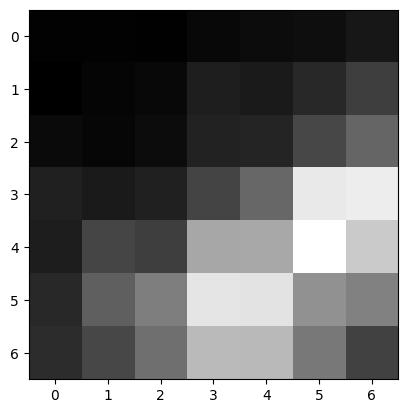

[('spindle', '29.8%'), ('soap dispenser', '12.8%'), ('lotion', '10.9%'), ('perfume, essence', '2.3%'), ('nipple', '1.8%')]


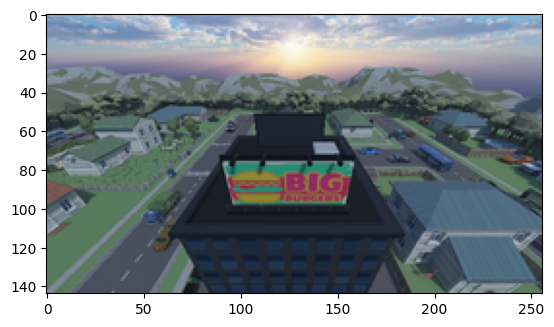

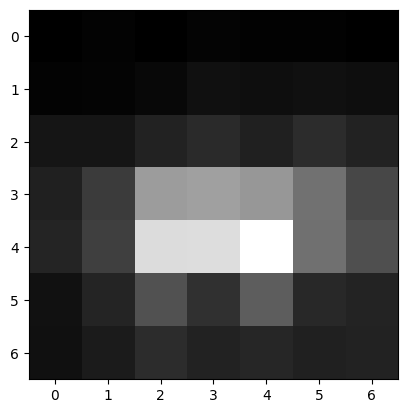

[('shopping basket', '11.5%'), ('ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin', '10.1%'), ('garbage truck, dustcart', '6.1%'), ('monitor', '5.5%'), ('joystick', '4.7%')]


In [15]:
for ii, (uri, result) in enumerate(zip(uris, results)):
    if ii < 7:
        img = Image.open(requests.get(uri, stream=True).raw)
    else:
        img = Image.open(uri)
        
    img.thumbnail(size=(256,256), resample=Image.ANTIALIAS)  
    attention = torch.sum(features[ii], dim=0).to('cpu')
    plt.imshow(img)
    plt.show()
    plt.imshow(attention, cmap='gray')
    plt.show()
    print(result)

In [21]:
check_memory(device)

0.1GiB
0.3GiB


---

In [11]:
from torchvision import transforms

convert_tensor = transforms.ToTensor()

In [31]:
subj = '04'
resolution = (320,180)

In [32]:
dir_root = '/mnt/ext5/DRN/behav_data/DRN%s'%subj
dir_resize = join(dir_root,'resized_%dx%d'%(resolution[0],resolution[1]))

In [34]:
list_run = ['Run%d'%(rr+1) for rr in range(6)]

for run in list_run:
    print(run)
    check_memory(device)
    
    df = pd.read_json(join(dir_root,'%s/log.json'%run))

    dir_output = join(dir_resize,'%s_overlay'%run)
    os.makedirs(dir_output, exist_ok=True)

    list_ep = np.unique(df.Episode)
    for ep in tqdm(list_ep):
        ## load underlays
        underlay = []
        list_png = df[df.Episode==ep].ScreenShot.values
        for png in list_png:
            step = int(png.split('.')[0])
            fname = join(dir_resize,'%s/%05d.png'%(run,step))
            with Image.open(fname) as f:
                underlay.append(convert_tensor(f))

        ## get features
        batch = torch.stack(underlay, dim=0).to(device)
        with torch.no_grad():
            features = feature_extractor(batch)['res5']
        feature_sum = torch.sum(features, dim=1).to('cpu')

        feature_sum = feature_sum.numpy()
        feature_max = feature_sum.max(axis=(1,2))

        ## make overlays then aplly Gaussian filter to it
        list_overlay = np.array([feature_sum[tt]/max_ for tt, max_ in enumerate(feature_max)])*255
        for ii, tmp in enumerate(list_overlay):
            img = Image.fromarray(tmp.astype(np.uint8), mode='L')
            img = img.filter(ImageFilter.GaussianBlur(radius=1))
            ## save the overlay
            overlay = img.resize(size=resolution, resample=Image.Resampling.LANCZOS)
            step = int(list_png[ii].split('.')[0])
            plt.imsave(
                fname = join(dir_output,'%05d.png'%step)
                , arr = overlay
                , cmap = plt.cm.jet
            )

/home/sungbeenpark/anaconda3/envs/attention/lib/python3.9/site-packages/torch/cuda/memory.py:395: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


Run1
0.2GiB
8.7GiB


100%|██████████| 65/65 [00:54<00:00,  1.19it/s]
/home/sungbeenpark/anaconda3/envs/attention/lib/python3.9/site-packages/torch/cuda/memory.py:395: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


Run2
0.2GiB
8.7GiB


100%|██████████| 70/70 [00:55<00:00,  1.27it/s]
/home/sungbeenpark/anaconda3/envs/attention/lib/python3.9/site-packages/torch/cuda/memory.py:395: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


Run3
0.2GiB
8.7GiB


100%|██████████| 74/74 [00:55<00:00,  1.34it/s]
/home/sungbeenpark/anaconda3/envs/attention/lib/python3.9/site-packages/torch/cuda/memory.py:395: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


Run4
0.1GiB
8.7GiB


100%|██████████| 55/55 [00:54<00:00,  1.01it/s]
/home/sungbeenpark/anaconda3/envs/attention/lib/python3.9/site-packages/torch/cuda/memory.py:395: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


Run5
0.2GiB
8.7GiB


100%|██████████| 57/57 [00:54<00:00,  1.04it/s]
/home/sungbeenpark/anaconda3/envs/attention/lib/python3.9/site-packages/torch/cuda/memory.py:395: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


Run6
0.3GiB
16.6GiB


100%|██████████| 52/52 [00:54<00:00,  1.06s/it]


In [ ]:
# # a colormap and a normalization instance
# cmap = plt.cm.jet
# norm = plt.Normalize(vmin=data.min(), vmax=data.max())

# # map the normalized data to colors
# # image is now RGBA (512x512x4) 
# image = cmap(norm(data))

---

To overlap the underlay and the overlay

In [74]:
run = 'Run1'
list_underlay = sorted(glob(join(dir_resize, '%s/*png'%run)))
list_overlay = sorted(glob(join(dir_resize, '%s_overlay/*png'%run)))

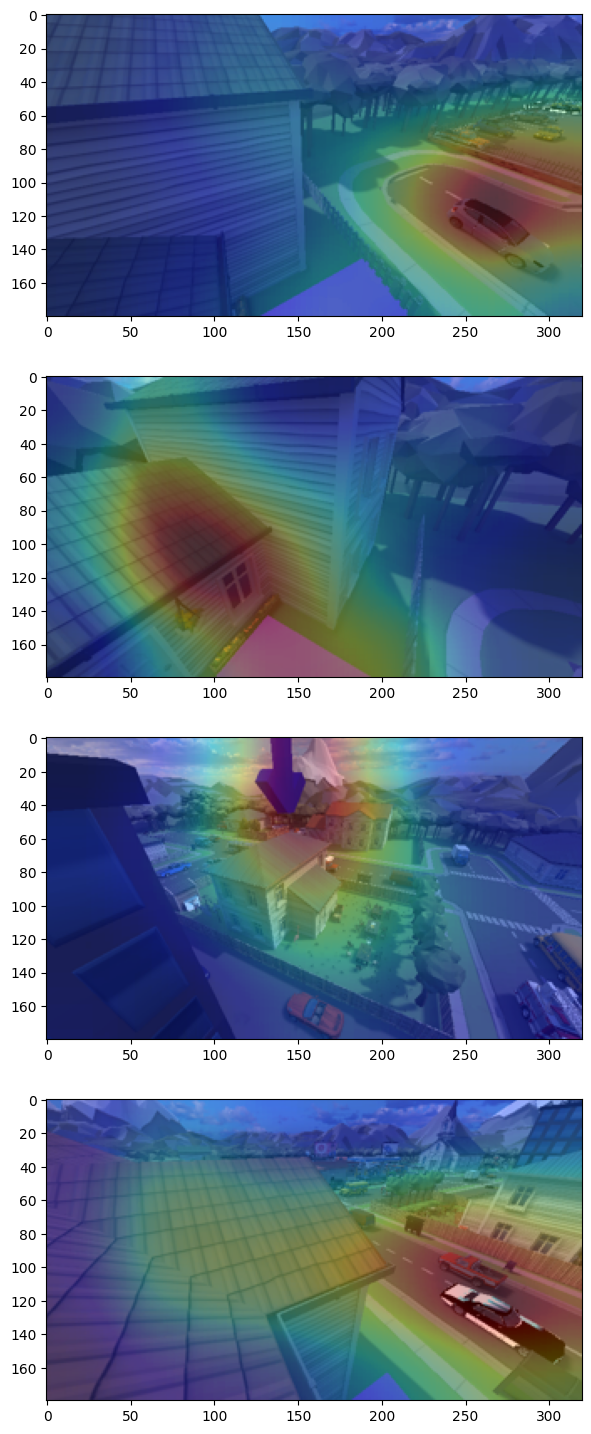

In [81]:
list_fname = np.random.choice(list_underlay, size=4, replace=False)

nrows = len(list_fname)
fig, axs = plt.subplots(nrows=nrows, figsize=(8,4.5*nrows))

for ii, fname in enumerate(list_fname):
    ax = axs[ii]
    underlay = Image.open(fname)
    overlay = Image.open(fname.replace(run,'%s_overlay'%run))
    img = Image.blend(underlay.convert('RGBA'), overlay.convert('RGBA'), alpha=0.3)
    ax.imshow(img)